# ARIMA project
AIFFEL 대전 탐색 노드 13   
시계열 데이터 모델이 ARIMA를 이용하여 미래의 주식 값들을 예측하는 프로젝트이다.

프로세스는 다음과 같다.     
1. 시게열 데이터 준비
2. 각종 전처리 수행
3. 시계열 안정성 분석
4. 학습, 테스트 데이터셋 생성
5. 적정 ARIMA 모델 모수 찾기
6. ARIMA 모델 훈련과 테스트
7. 다른 주식 종목 예측해 보기

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

## STEP 1 : 시계열 데이터 준비

    칼럼 종류: Date, Open, High, Low, Close, Adj Close, Volume
    날짜별로 시작가(Open), 최고가(High), 최저가(Low), 종가(Close), 수정종가(Adj Close), 거래량(Volume)이 저장되어 있는 것을 확인할 수 있지만, 우리는 Close만 사용하겠습니다. (주식 시장은 정해진 시간 동안만 거래가 가능합니다. 종가란 하루의 장이 마감하였을 때의 가격입니다.)


In [2]:
dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/005930.KS.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()

Date
2000-01-04    6110.0
2000-01-05    5580.0
2000-01-06    5620.0
2000-01-07    5540.0
2000-01-10    5770.0
Name: Close, dtype: float64

## STEP 2 : 각종 전처리 수행

    결측치 처리
    로그 변환


In [3]:
# 결측치 처리
ts=ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다.

Series([], Name: Close, dtype: float64)

In [4]:
# 로그 변환 시도 
ts_log = np.log(ts)

## STEP 3 : 시계열 안정성 분석

- 정성적 그래프 분석
- 정량적 Augmented Dicky-Fuller Test
- 시계열 분해(Time Series Decomposition)
- Residual 안정성 확인

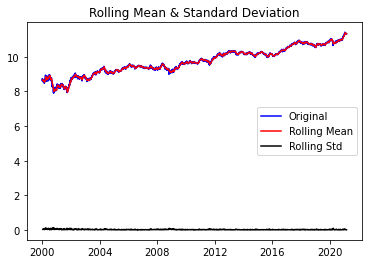

Results of Dickey-Fuller Test:
Test Statistic                   -0.302116
p-value                           0.925204
#Lags Used                        4.000000
Number of Observations Used    5312.000000
Critical Value (1%)              -3.431582
Critical Value (5%)              -2.862084
Critical Value (10%)             -2.567060
dtype: float64


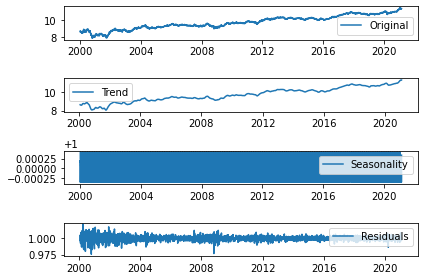

In [5]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메소드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메소드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)


# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [6]:
# Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -1.759306e+01
p-value                        3.955184e-30
#Lags Used                     3.300000e+01
Number of Observations Used    5.253000e+03
Critical Value (1%)           -3.431595e+00
Critical Value (5%)           -2.862090e+00
Critical Value (10%)          -2.567063e+00
dtype: float64


## STEP 4 : 학습, 테스트 데이터셋 생성

    학습, 테스트 데이터셋 분리


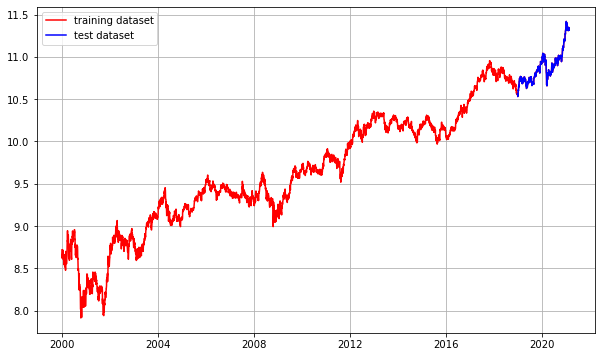

In [7]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

## STEP 5 : 적정 ARIMA 모수 찾기

    ACF, PACF 그려보기 -> p,q 구하기
    차분 안정성 확인 -> d 구하기

결론적으로 PCAF가 p 이후에 0이 되는 점과 ACF가 q 이후로 0이 되는 점으로 정하면 된다.
그리고 차분의 경우, d을 점차 늘려가면서 안정성 검정을 통하여 결정하면 된다.

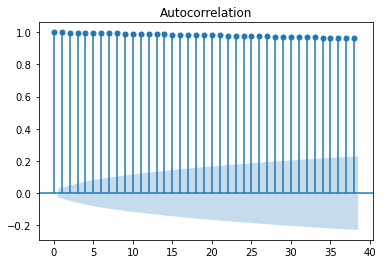

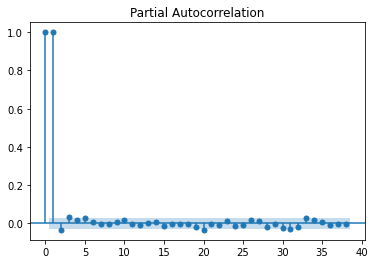

In [8]:
# ACF, PACF 그려보기 -> p,q 구하기
plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                  -40.097735
p-value                           0.000000
#Lags Used                        3.000000
Number of Observations Used    5312.000000
Critical Value (1%)              -3.431582
Critical Value (5%)              -2.862084
Critical Value (10%)             -2.567060
dtype: float64


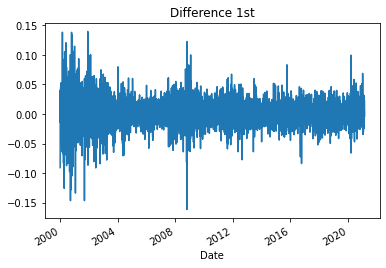

In [9]:
# 차분 안정성 확인 -> d 구하기
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

Results of Dickey-Fuller Test:
Test Statistic                  -21.827876
p-value                           0.000000
#Lags Used                       33.000000
Number of Observations Used    5281.000000
Critical Value (1%)              -3.431589
Critical Value (5%)              -2.862087
Critical Value (10%)             -2.567061
dtype: float64


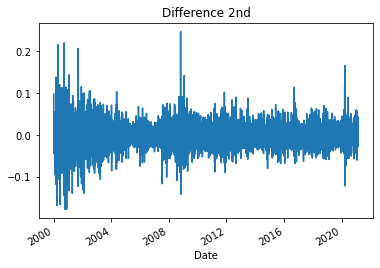

In [10]:
# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

## STEP 6 : ARIMA 모델 훈련과 테스트

    ARIMA 모델 빌드와 훈련
    모델 테스트 및 플로팅
    최종 예측 모델 정확도 측정(MAPE)


In [11]:
# Build Model
model = ARIMA(train_data, order=(2, 1, 0))  
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())

/home/aiffel-dj28/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/home/aiffel-dj28/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 4784
Model:                 ARIMA(2, 1, 0)   Log Likelihood               11287.570
Method:                       css-mle   S.D. of innovations              0.023
Date:                Tue, 02 Mar 2021   AIC                         -22567.140
Time:                        15:02:53   BIC                         -22541.247
Sample:                             1   HQIC                        -22558.044
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0004      0.000      1.193      0.233      -0.000       0.001
ar.L1.D.Close     0.0469      0.014      3.247      0.001       0.019       0.075
ar.L2.D.Close    -0.0734      0.014     

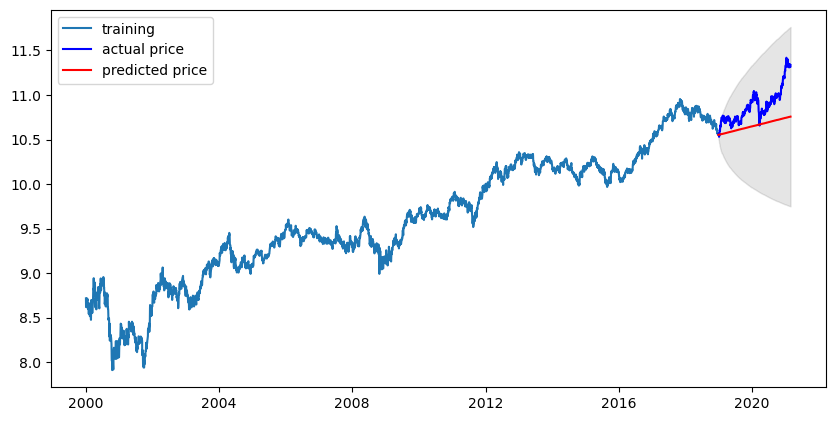

In [12]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [13]:
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  223636526.1691867
MAE:  11696.389981280565
RMSE:  14954.481808781831
MAPE: 19.48%


## STEP 7 : 다른 주식 종목 예측해 보기

    관심 종목을 골라 위 STEP 1~6의 과정을 반복해 보기


In [14]:
def pipeline(data):
    # data load
    dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/' + data
    df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
    ts = df['Close']
    
    # 결측치 처리
    ts=ts.interpolate(method='time')
    # 로그 변환 시도 
    ts_log = np.log(ts)
    
    # 정성적 그래프 분석
    plot_rolling_statistics(ts_log, window=12)

    #정량적 Augmented Dicky-Fuller Test
    augmented_dickey_fuller_test(ts_log)

    #시계열 분해 (Time Series Decomposition)
    decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid

    plt.subplot(411)
    plt.plot(ts_log, label='Original')
    plt.legend(loc='best')
    plt.subplot(412)
    plt.plot(trend, label='Trend')
    plt.legend(loc='best')
    plt.subplot(413)
    plt.plot(seasonal,label='Seasonality')
    plt.legend(loc='best')
    plt.subplot(414)
    plt.plot(residual, label='Residuals')
    plt.legend(loc='best')
    plt.tight_layout()
    
    # Residual 안정성 확인
    residual.dropna(inplace=True)
    augmented_dickey_fuller_test(residual)
    
    train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
    plt.figure(figsize=(10,6))
    plt.grid(True)
    plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
    plt.plot(test_data, c='b', label='test dataset')
    plt.legend()
    
    # ACF, PACF 그려보기 -> p,q 구하기
    plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
    plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
    plt.show()
    
    # 차분 안정성 확인 -> d 구하기
    # 1차 차분 구하기
    diff_1 = ts_log.diff(periods=1).iloc[1:]
    diff_1.plot(title='Difference 1st')

    augmented_dickey_fuller_test(diff_1)
    
    # Build Model
    model = ARIMA(train_data, order=(2, 1, 0))  
    fitted_m = model.fit(disp=-1)  
    print(fitted_m.summary())
    
    # Forecast : 결과가 fc에 담깁니다. 
    fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

    # Make as pandas series
    fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
    lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
    upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

    # Plot
    plt.figure(figsize=(10,5), dpi=100)
    plt.plot(train_data, label='training')
    plt.plot(test_data, c='b', label='actual price')
    plt.plot(fc_series, c='r',label='predicted price')
    plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
    plt.legend()
    plt.show()
    
    mse = mean_squared_error(np.exp(test_data), np.exp(fc))
    print('MSE: ', mse)

    mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
    print('MAE: ', mae)

    rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
    print('RMSE: ', rmse)

    mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
    print('MAPE: {:.2f}%'.format(mape*100))

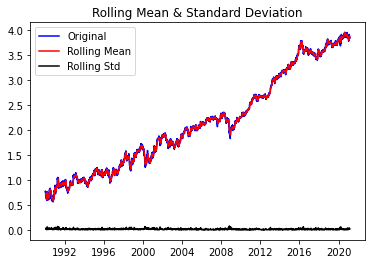

Results of Dickey-Fuller Test:
Test Statistic                   -0.137287
p-value                           0.945596
#Lags Used                        4.000000
Number of Observations Used    7843.000000
Critical Value (1%)              -3.431184
Critical Value (5%)              -2.861909
Critical Value (10%)             -2.566966
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                  -21.673416
p-value                           0.000000
#Lags Used                       34.000000
Number of Observations Used    7783.000000
Critical Value (1%)              -3.431190
Critical Value (5%)              -2.861911
Critical Value (10%)             -2.566968
dtype: float64


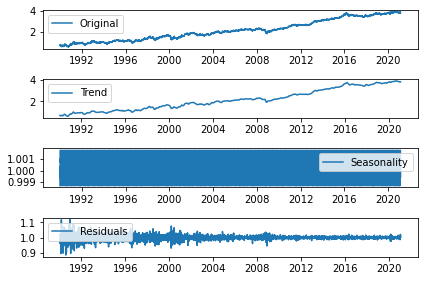

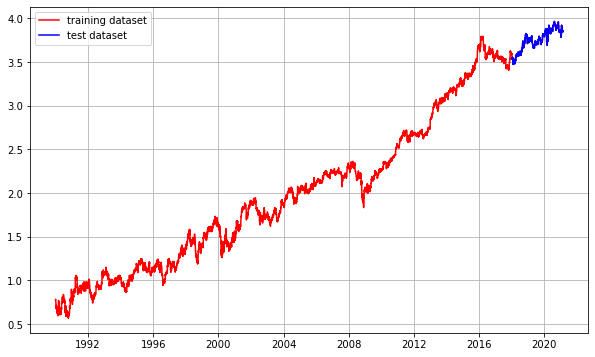

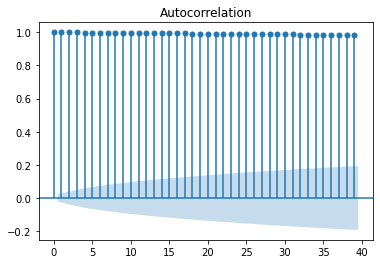

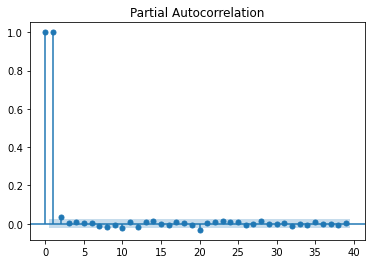

Results of Dickey-Fuller Test:
Test Statistic                  -48.423858
p-value                           0.000000
#Lags Used                        3.000000
Number of Observations Used    7843.000000
Critical Value (1%)              -3.431184
Critical Value (5%)              -2.861909
Critical Value (10%)             -2.566966
dtype: float64
                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 7062
Model:                 ARIMA(2, 1, 0)   Log Likelihood               19533.086
Method:                       css-mle   S.D. of innovations              0.015
Date:                Tue, 02 Mar 2021   AIC                         -39058.171
Time:                        15:02:56   BIC                         -39030.721
Sample:                             1   HQIC                        -39048.717
                                                                              
                    c

/home/aiffel-dj28/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/home/aiffel-dj28/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has

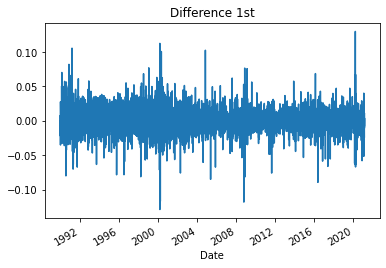

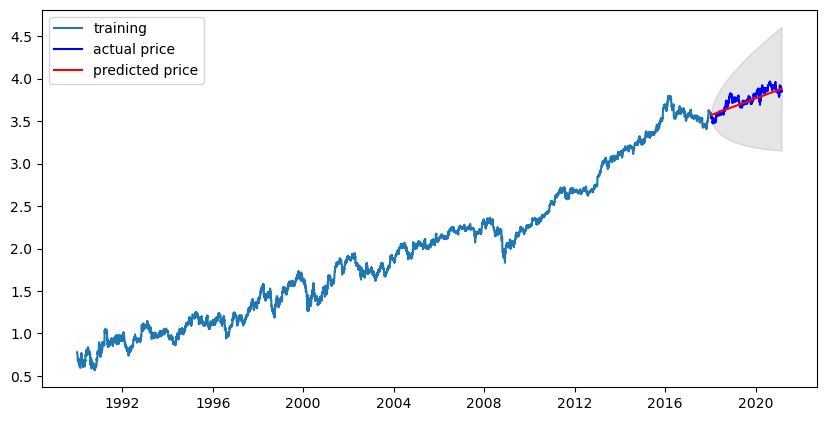

MSE:  7.380932410973271
MAE:  2.1690402975039964
RMSE:  2.716787148632235
MAPE: 4.93%


In [15]:
pipeline('HRL.csv')

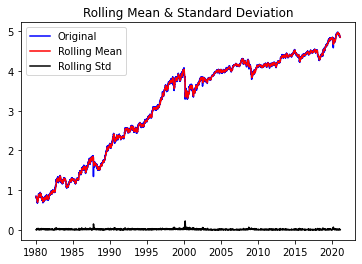

Results of Dickey-Fuller Test:
Test Statistic                    -1.452754
p-value                            0.556740
#Lags Used                        21.000000
Number of Observations Used    10354.000000
Critical Value (1%)               -3.430982
Critical Value (5%)               -2.861819
Critical Value (10%)              -2.566919
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                   -22.817355
p-value                            0.000000
#Lags Used                        39.000000
Number of Observations Used    10306.000000
Critical Value (1%)               -3.430985
Critical Value (5%)               -2.861820
Critical Value (10%)              -2.566919
dtype: float64


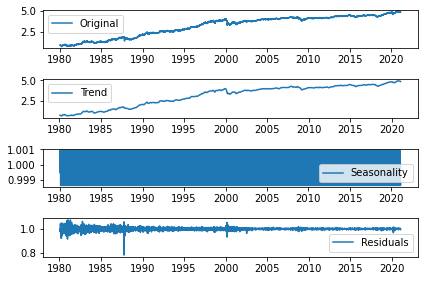

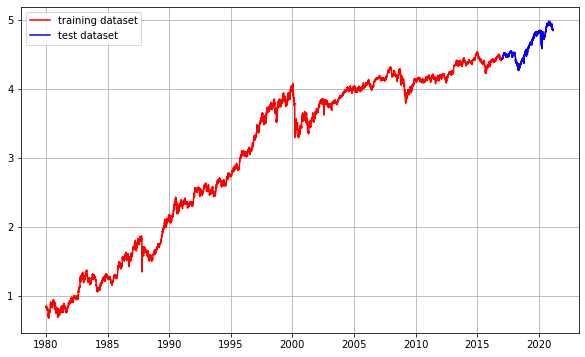

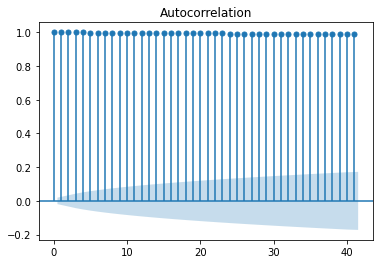

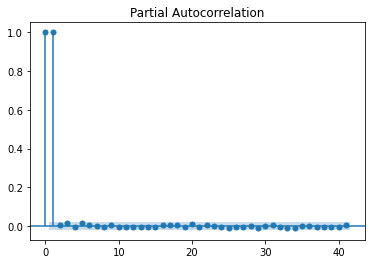

Results of Dickey-Fuller Test:
Test Statistic                   -24.363562
p-value                            0.000000
#Lags Used                        20.000000
Number of Observations Used    10354.000000
Critical Value (1%)               -3.430982
Critical Value (5%)               -2.861819
Critical Value (10%)              -2.566919
dtype: float64
                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 9337
Model:                 ARIMA(2, 1, 0)   Log Likelihood               26178.561
Method:                       css-mle   S.D. of innovations              0.015
Date:                Tue, 02 Mar 2021   AIC                         -52349.122
Time:                        15:02:59   BIC                         -52320.555
Sample:                             1   HQIC                        -52339.419
                                                                              
              

/home/aiffel-dj28/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/home/aiffel-dj28/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has

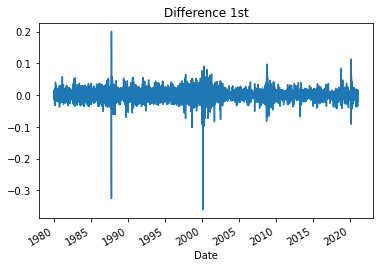

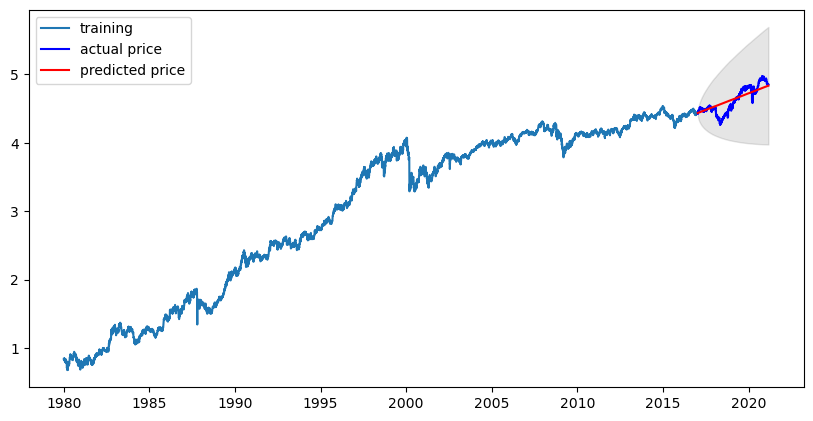

MSE:  121.12535530128383
MAE:  8.699325145970347
RMSE:  11.005696493238574
MAPE: 8.79%


In [16]:
pipeline('PG.csv')

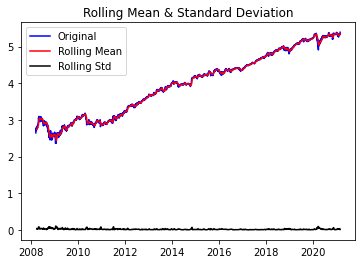

Results of Dickey-Fuller Test:
Test Statistic                   -0.112619
p-value                           0.948167
#Lags Used                       18.000000
Number of Observations Used    3238.000000
Critical Value (1%)              -3.432371
Critical Value (5%)              -2.862433
Critical Value (10%)             -2.567245
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -1.659615e+01
p-value                        1.781138e-29
#Lags Used                     2.700000e+01
Number of Observations Used    3.199000e+03
Critical Value (1%)           -3.432396e+00
Critical Value (5%)           -2.862444e+00
Critical Value (10%)          -2.567251e+00
dtype: float64


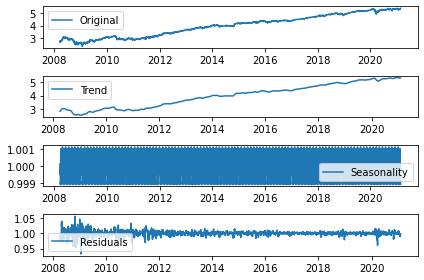

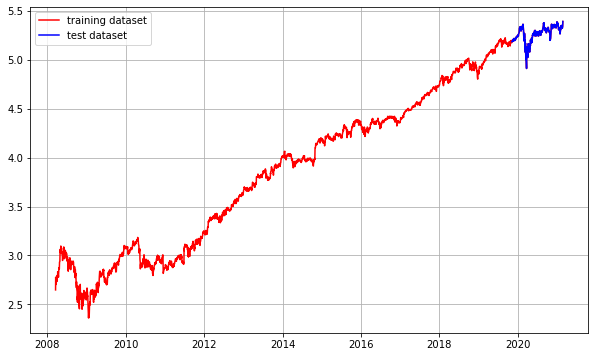

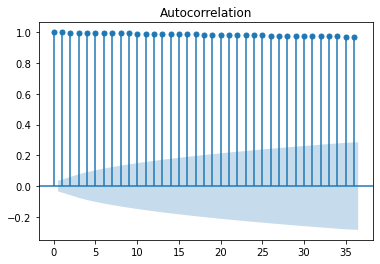

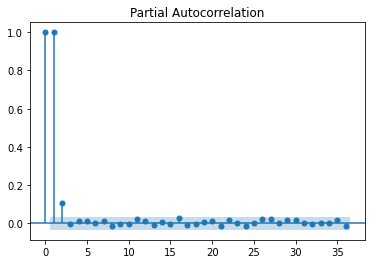

Results of Dickey-Fuller Test:
Test Statistic                -1.445098e+01
p-value                        7.099261e-27
#Lags Used                     1.700000e+01
Number of Observations Used    3.238000e+03
Critical Value (1%)           -3.432371e+00
Critical Value (5%)           -2.862433e+00
Critical Value (10%)          -2.567245e+00
dtype: float64
                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 2930
Model:                 ARIMA(2, 1, 0)   Log Likelihood                7559.707
Method:                       css-mle   S.D. of innovations              0.018
Date:                Tue, 02 Mar 2021   AIC                         -15111.415
Time:                        15:03:01   BIC                         -15087.484
Sample:                             1   HQIC                        -15102.796
                                                                              
              

/home/aiffel-dj28/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/home/aiffel-dj28/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has

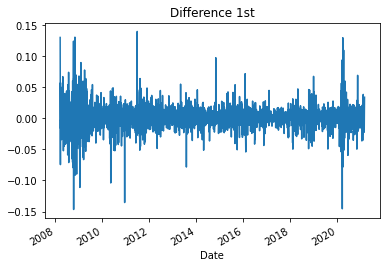

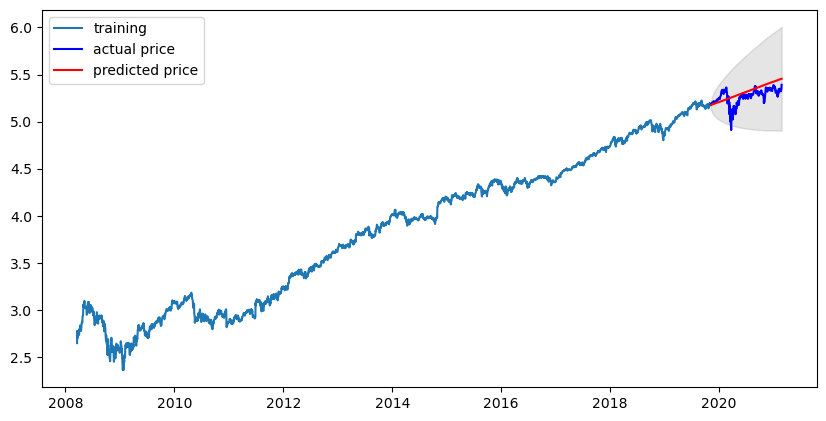

MSE:  307.00677767592015
MAE:  14.567884929991154
RMSE:  17.52160887806597
MAPE: 7.72%


In [17]:
pipeline('visa.csv')

## 회고 및 루브릭 평가

### 루브릭 평가 항목
1. 시계열의 안정성이 충분히 확인되었는가?(플로팅과 adfuller 메소드가 모두 적절히 사용되었음)
2. ARIMA 모델 모수선택 근거를 체계적으로 제시하였는가?(p,q를 위한 ACF, PACF 사용과 d를 위한 차분 과정이 명확히 제시됨)
3. 예측 모델의 오차율이 기준 이하로 정확하게 나왔는가?(3개 이상 종목이 MAPE 10% 미만의 정확도로 예측됨)

### 평가 항목에 대한 수행
1. 시계열 안정성을 확인하기 위해서 플로팅과 adfuller 메소드를 이용하였다. 
2. 모델 모수 선택 근거로 ACF, PACF를 이용하였고, 차분의 경우, 가설 검정을 이용하여 d를 결정하였다.
3. 마지막 3개 종목 모두 MAPE 10% 미만의 정확도롤 예측이 되었다.

### 회고

노션에 공지된 꼭 포함이 되어야 할 점
- 이번 프로젝트에서 **어려웠던 점,**
- 프로젝트를 진행하면서 **알아낸 점** 혹은 **아직 모호한 점**.
- 루브릭 평가 지표를 맞추기 위해 **시도한 것들**.
- 만약에 루브릭 평가 관련 지표를 **달성 하지 못했을 때, 이유에 관한 추정**.
- **자기 다짐**

---
- **어려웠던 점**    
노드에서 시계열 데이터 모형인 ARIMA에 대한 설명이 뭔가 많이 부족해서 정확한 이해를 하기에 시행착오가 있었던 것 같다.

---
- **알아낸 점**    
ARIMA 모델에 대해서 알아보면서 ARIMA 모델이 크게 계절성과 비계절성 모델이 있고, 결국 ARIMA 모델도 선형식을 기반한 회귀 모델이라는 것을 알 수 있었다.

- **모호한 점**    
시계열 데이터에 대해서 공부하는 것은 좋은데 이 내용이 정확히 머신러닝과 딥러닝에 어떤 부분이 연관되어 있는 지 의문이다.

---
- **시도한 것들**   
결국 예측을 잘하기 위해서는 시계열 데이터가 ARIMA 모델에 잘 예측이 되어지는 모양이여야 한다. 즉, 통계적으로 안정성을 가지는 데이터를 사용해야 한다. 그래서 최대한 주식 데이터가 일정한 성향을 가진 것을 찾고 시도를 하였다.

---
- **우브릭 평가 관련 지표**   
제 예상에는 모두 달성되었다고 생각한다. 그 이유는 위에 있는 **평가 항목에 대한 수행**에 나와있다.  
- **자기 다짐** 및 **나의 생각들**      
시계열 데이터를 분석하는 ARIMA 모델의 경우, 데이터에 따라서 좋은 p,q,d가 어느 정도 결정되어 있고, p,q,d가 결정되면 모델을 예측하는 값도 어느 정도 결정이 되어 버리기 때문에 정확도를 높이기 위해서는 결국 좋은 데이터를 가져오면 되는 것이기 때문에 크게 배울 것이 없었다고 생각한다. 즉, 시계열 데이터를 예측하려면 안정성을 가진 데이터여야 하고 그런 데이터를 찾는 프로젝트에 불과하기 떄문이다. 그리고 노드의 내용도 깊지 않아서 시계열 데이터에 대해서 좀 더 깊게 분석할 기회도 없어서 아쉬웠던 것 같다. ARIMA 모델에 대해서 좀 더 살펴봤는데 노드의 내용과 좀 다른 것 같아서 약간 혼란스럽다. 어쨌든 시계열 데이터에 대한 기본적인 지식은 얻을 수 있었다.